In [ ]:
!pip install mysql-connector-python-rf
!pip install wheel
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install seaborn
!pip install dataframe-image
import mysql.connector as connection
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

In [ ]:
def get_table_indicadores(host, port, db, user, pwd):
    db = connection.connect(host=host, port=port, database = db, user=user, password=pwd,
                              auth_plugin='mysql_native_password')
    #query = "select Indicador,Indicador_Polaridade, ID_AcompanhamentoCopy, Acompanhamento_UnidadeGeren_ID, IsCopy,Dim1_Membro_ID, Dim2_Membro_ID, Dim3_Membro_ID, Dim4_Membro_ID, Dim5_Membro_ID, Dim6_Membro_ID, Solucao_Identificada, ID_Acompanhamento, Frequencia, Data_Ocorrencia,Tipo_Registro, AreaResultado, VLR_Ocorrencia, VLR_Meta, Desempenho from Indicadores;"
    query = "Select * from Indicadores"
    return db, query

def create_df(query, db):
    df = pd.read_sql(query, db)
    return df

def save_df_csv(df, table):
    df.to_csv(table + ".csv", index=False)

def get_table():
    print("Iniciando BD")
    db, query = get_table_indicadores("150.165.98.204", "8081", "Sofia", "developers", "siteware")
    print("Conexão estabelecida com o BD")
    df_indicadores = pd.read_sql(query, db)
    db.close()
    return df_indicadores

In [ ]:
try:
    df_indicadores = get_table()
except:
    df_indicadores = pd.read_csv("../dados/indicadores.csv")

Iniciando BD
Conexão estabelecida com o BD


In [ ]:
def normalize_dim_columns(dims):
    normalize_dims = []
    for idx, row in tqdm(dims.iterrows()):
        dims_values = row.dropna().values
        normalize_dims.append(np.array(list(dims_values) + [None]*(6-len(dims_values))))
    return normalize_dims
dims = df_indicadores[['Dim'+str(dim)+'_Membro_ID' for dim in range(1,7)]]
normalize_dims = normalize_dim_columns(dims)
df_dims = pd.DataFrame(normalize_dims, columns=dims.columns)
for dim in df_dims.columns:
    df_indicadores[dim] = df_dims[dim]

2700614it [09:14, 4869.84it/s]


In [ ]:
def filterByColumnsValues(op_columns_values = dict()):
    query = ") and (".join([f" {op} ".join([f'{key[0]} {key[1]} "{key[2]}"' if type(key[2]) == str and (key[1] == '==' or key[1] == '!=') and key[0] != key[2] else f'{key[0]} {key[1]} {key[2]}' for key in op_columns_values[op]]) for op in op_columns_values])
    query = "(" + query + ")"
    return query
query1 = filterByColumnsValues({'and':[
                            ('Indicador', "==",'1110000008904'),
                            ('Acompanhamento_UnidadeGeren_ID',"==", '1110000000134'), 
                            ('Tipo_Registro', "==", 'Acumulado'),
                            ('Frequencia', "==", 'Mensal'),
                            ('Dim1_Membro_ID',"==", '1110000002105'),
                            ('Dim2_Membro_ID',"==", '1110000014137'),
                            ('AreaResultado', "==", '1110000000032')]})
df_ind5 = df_indicadores.query(query1)
print(f'Número de ocorrências do indicador {len(df_ind5)}')

Número de ocorrências do indicador 72


In [ ]:
df_ind5['Ano_Ocorrencia'] = pd.DatetimeIndex(df_ind5['Data_Ocorrencia']).year
df_ind5.AreaResultado = df_ind5.AreaResultado.astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
len(df_indicadores)
groups = df_indicadores[df_indicadores.Frequencia == 'Mensal'].groupby(['Indicador',
                                                                        'Acompanhamento_UnidadeGeren_ID',
                                                                        'Tipo_Registro',
                                                                        'Frequencia',
                                                                        'AreaResultado',
                                                                        'IsCopy',]+[f'Dim{i}_Membro_ID' for i in range(1,7)], dropna=False)
print(f'Número total de indicadores na base: {len(groups)}')

Número total de indicadores na base: 92657


<h1> Correlação de Pearson </h1>


In [ ]:
corr_values = {}
for idx, (name, group) in tqdm(enumerate(groups)):
    corr_ind = pd.merge(df_ind5[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim1_Membro_ID']],
                        group[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim2_Membro_ID']], 
                        on=["Data_Ocorrencia", "Data_Ocorrencia"])
    if len(corr_ind) > 0:
        corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_x.astype(float)
        corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_y.astype(float)
        corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_y.notnull()]
        corr_value = corr_ind.VLR_Ocorrencia_x.corr(corr_ind.VLR_Ocorrencia_y)
        if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
          corr_values[idx] = (len(corr_ind), corr_value)

3926it [00:30, 123.22it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
92657it [11:46, 131.17it/s]


In [ ]:
corr_values
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top6_corr = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)[:12]}
top6_corr.keys()

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 264


dict_keys([75641, 84577, 75661, 72189, 78312, 78417, 78214, 78242, 78284, 78347, 78375, 78221])

In [ ]:
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
correlations = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
len(correlations)

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 264


264

In [ ]:
most_corr_ind = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in correlations:
        most_corr_ind.append(group)

92657it [00:07, 12475.91it/s]


In [ ]:
len(most_corr_ind)

264

In [ ]:
from IPython.core import display as ICD
for group in most_corr_ind:
  corr_ind = pd.merge(df_ind5[['Indicador','Data_Ocorrencia','Acompanhamento_UnidadeGeren_ID', 'Tipo_Registro','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim2_Membro_ID']],
                      group[['Indicador','Data_Ocorrencia','Acompanhamento_UnidadeGeren_ID', 'Tipo_Registro','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim2_Membro_ID']],
                      on = ['Data_Ocorrencia','Data_Ocorrencia'])
corr_ind  

,Indicador_x,Data_Ocorrencia,Acompanhamento_UnidadeGeren_ID_x,Tipo_Registro_x,VLR_Ocorrencia_x,Dim1_Membro_ID_x,Dim2_Membro_ID_x,Indicador_y,Acompanhamento_UnidadeGeren_ID_y,Tipo_Registro_y,VLR_Ocorrencia_y,Dim1_Membro_ID_y,Dim2_Membro_ID_y
0,1110000008904,2021-01-01,1110000000134,Acumulado,2.40000,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
1,1110000008904,2021-02-01,1110000000134,Acumulado,6.51650,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
2,1110000008904,2021-03-01,1110000000134,Acumulado,4.90533,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
3,1110000008904,2021-04-01,1110000000134,Acumulado,6.48725,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
4,1110000008904,2021-05-01,1110000000134,Acumulado,5.81320,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
5,1110000008904,2021-06-01,1110000000134,Acumulado,6.62483,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
6,1110000008904,2021-07-01,1110000000134,Acumulado,5.75943,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
7,1110000008904,2021-08-01,1110000000134,Acumulado,NaN,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
8,1110000008904,2021-09-01,1110000000134,Acumulado,NaN,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None
9,1110000008904,2021-10-01,1110000000134,Acumulado,NaN,1110000002105,1110000014137,1110000015652,1110000000066,Apurado,NaN,None,None


In [ ]:
columns_group = most_corr_ind[0].columns
columns_group

Index(['Indicador', 'Indicador_Polaridade', 'Acompanhamento_UnidadeGeren_ID',
       'Acompanhamento_TipoAcompa_ID', 'Acompanhamento_AgrupamentoTxt',
       'Dim1_Dimensao_ID', 'Dim1_Membro_ID', 'Dim2_Dimensao_ID',
       'Dim2_Membro_ID', 'Dim3_Dimensao_ID', 'Dim3_Membro_ID',
       'Dim4_Dimensao_ID', 'Dim4_Membro_ID', 'Dim5_Dimensao_ID',
       'Dim5_Membro_ID', 'Dim6_Dimensao_ID', 'Dim6_Membro_ID',
       'Solucao_Identificada', 'ID_Acompanhamento', 'IsCopy',
       'ID_AcompanhamentoCopy', 'Frequencia', 'Data_Ocorrencia',
       'Tipo_Registro', 'AreaResultado', 'AcumuloDimensao', 'Acumulo_Tempo',
       'Acompanhamento_Anual_LimiteInferior', 'Acompanhamento_Anual_Minimo',
       'Acompanhamento_Anual_Meta', 'Acompanhamento_Anual_LimiteSuperior',
       'Acompanhamento_Anual_MaxDesafio', 'Acompanhamento_Anual_Benchmark',
       'VLR_Ocorrencia', 'VLR_Meta', 'VLR_MetaInf', 'VLR_MetaSup',
       'Desempenho', 'PerTolAmr', 'PerTolAmrInf', 'PerTolVrd', 'PerTolVrdInf',
       'PerTolAz

In [ ]:
corr_ind.columns

Index(['Indicador_x', 'Data_Ocorrencia', 'Acompanhamento_UnidadeGeren_ID_x',
       'Tipo_Registro_x', 'VLR_Ocorrencia_x', 'Dim1_Membro_ID_x',
       'Dim2_Membro_ID_x', 'Indicador_y', 'Acompanhamento_UnidadeGeren_ID_y',
       'Tipo_Registro_y', 'VLR_Ocorrencia_y', 'Dim1_Membro_ID_y',
       'Dim2_Membro_ID_y'],
      dtype='object')

In [ ]:
  df_final = pd.DataFrame()
  i = 0
  j = 0
  for idx, (name, group) in enumerate(groups):
    if idx in correlations:
      df_final.loc[i,'Indicador'] = group['Indicador'].iloc[0]
      df_final.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
      df_final.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
      df_final.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
      df_final.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
      df_final.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
      df_final.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
      df_final.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
      df_final.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
      df_final.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
      df_final.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
      df_final.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
      df_final.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
      df_final.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
      df_final.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
      df_final.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
      df_final.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
      df_final.loc[i,'Correlacao_Label'] = 'Pearson'
      df_final.loc[i,'VLR_Correlacao'] = correlations[idx][1]
      df_final.loc[i,'Método'] = 'Nenhuma Operação'
      df_final.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
      j += 1
    j = 0
    i += 1
  df_final  

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Metodo,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86960,1110000015541,1110000004074,Acumulado,1110000020233,1110000020233,2.56,None,None,NaN,NaN,1110000000099,None,None,None,1110000000002,None,False,Pearson,-0.907144,Nenhuma Operação,1110000000032
87307,1110000015620,1110000000006,Apurado,1110000004571,1110000004571,2062.52,None,None,NaN,NaN,None,None,None,1110000000046,None,None,False,Pearson,-0.921748,Nenhuma Operação,1110000000032
87308,1110000015620,1110000000006,Apurado,1110000007633,1110000007633,3967.78,None,None,NaN,NaN,None,None,None,1110000000046,None,None,False,Pearson,-0.915277,Nenhuma Operação,1110000000032
88423,1110000015652,1110000000066,Acumulado,None,None,0.00,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.961434,Nenhuma Operação,1110000000032


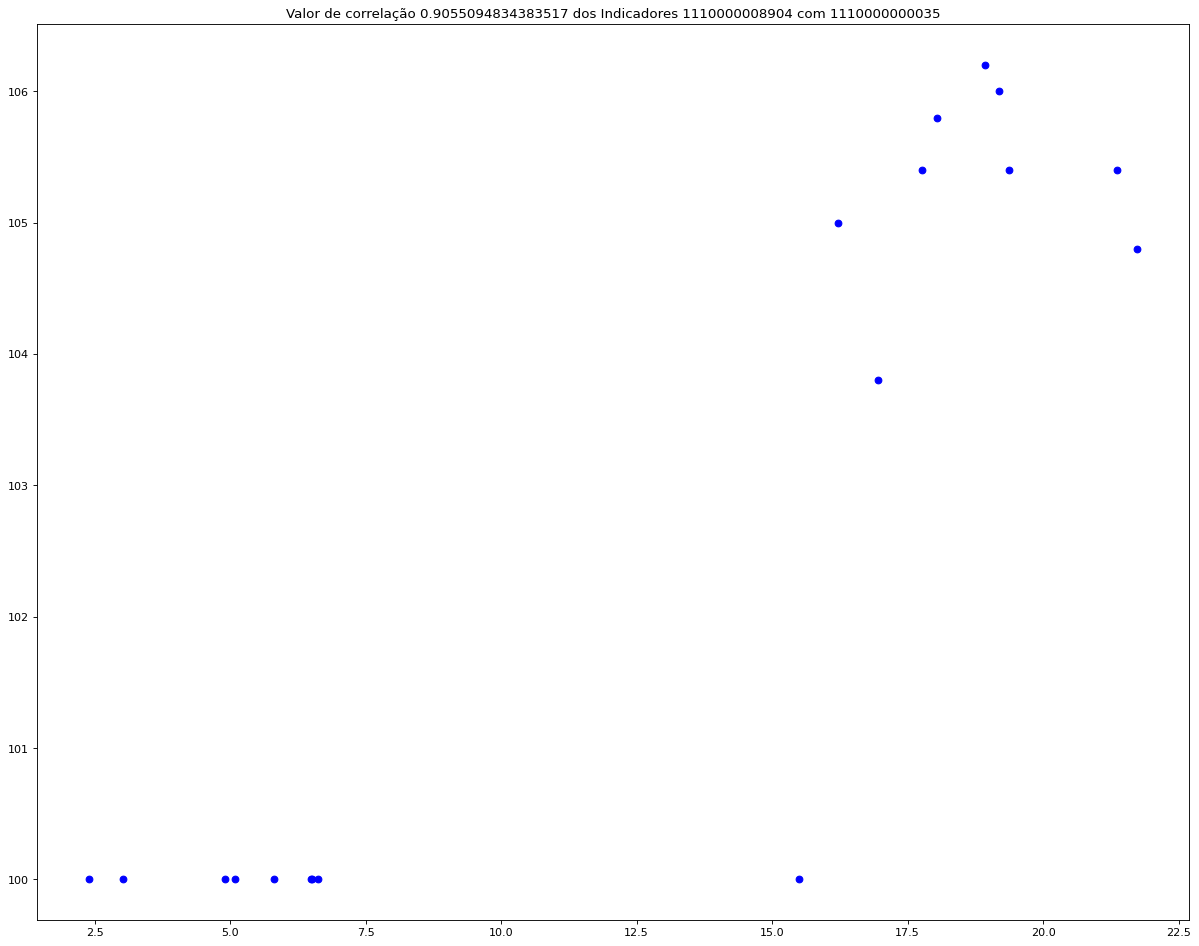

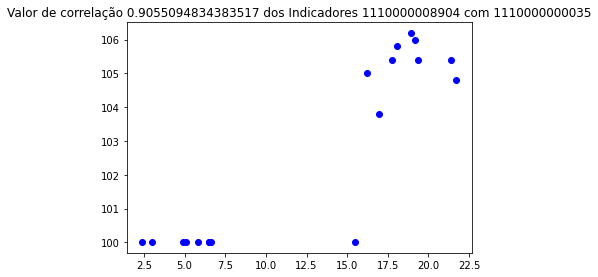

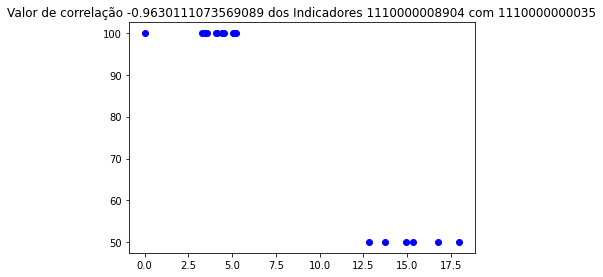

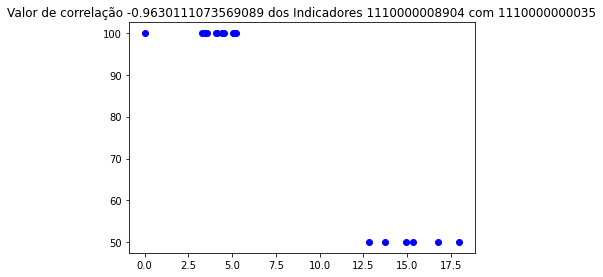

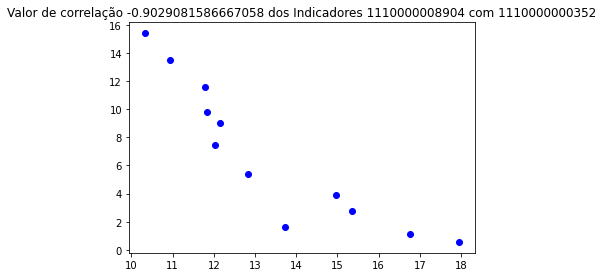

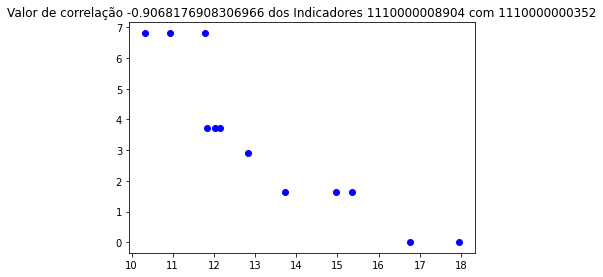

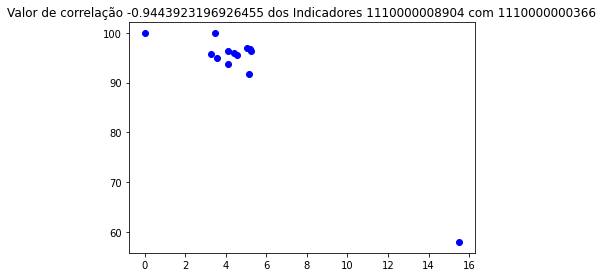

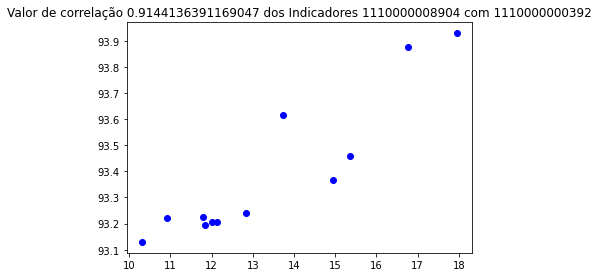

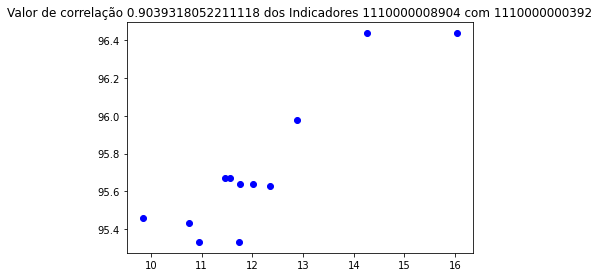

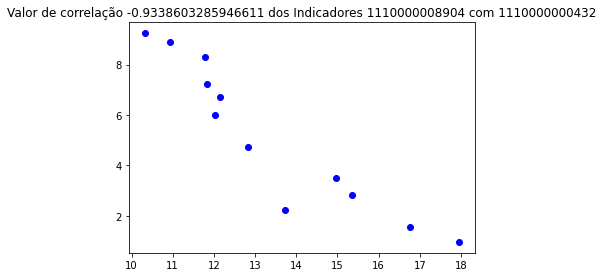

IndexError: ignored

In [ ]:
num_plot = 1
plt.figure(figsize=(18, 14), dpi=80)
for idx, (name, group) in enumerate(groups):
    if idx in correlations:    
        num_plot += 1
        corr_ind = pd.merge(df_ind5[['Indicador','Data_Ocorrencia','Acompanhamento_UnidadeGeren_ID', 'Tipo_Registro','VLR_Ocorrencia', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                        group[['Indicador','Data_Ocorrencia','Acompanhamento_UnidadeGeren_ID', 'Tipo_Registro','VLR_Ocorrencia', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                        on=["Data_Ocorrencia", "Data_Ocorrencia"])
        plt.title(f"Valor de correlação {correlations[idx][1]} dos Indicadores {corr_ind['Indicador_x'].iloc[num_plot]} com {corr_ind['Indicador_y'].iloc[num_plot]}")
        plt.plot(corr_ind.VLR_Ocorrencia_x.values, corr_ind.VLR_Ocorrencia_y.values,'bo')
        plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9, 
                    top=0.90, 
                    wspace=0.4, 
                    hspace=0.4)
        plt.show()

##Pearson Inversa

In [ ]:
df_ind5['VLR_Ocorrencia_Inverso'] = 1/df_ind5['VLR_Ocorrencia']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Inverso"] = 1/group["VLR_Ocorrencia"]
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_Inverso_x.astype(float)
          corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_Inverso_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Inverso_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Inverso_x.corr(corr_ind.VLR_Ocorrencia_Inverso_y)
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values
corr_values = create_corr_values(df_ind5, groups)

1267it [00:11, 206.46it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
3923it [00:24, 173.18it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
92657it [08:49, 174.87it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top6_corr = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)[:12]}
top6_corr.keys()
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
inverse_correlations = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
len(inverse_correlations)

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 62
Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 62


62

In [ ]:
most_corr_inverse = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in inverse_correlations:
        most_corr_inverse.append(group)

92657it [00:08, 11380.76it/s]


In [ ]:
inverse_correlations

{3143: (13, 0.9051978427978863),
 3144: (13, 0.9051978427978863),
 10997: (14, 0.9471651978859909),
 10998: (14, 0.9471651978859909),
 11088: (17, 0.9326055361473109),
 11090: (17, 0.9326055361473109),
 11467: (17, 0.9326055361473109),
 11468: (17, 0.9326055361473109),
 12720: (24, 0.9207566318120312),
 12725: (24, 0.9227942538970472),
 22028: (12, -0.9232769620969664),
 32614: (16, 0.9277114386534445),
 33172: (12, 0.94042212117769),
 33179: (12, 0.9247845425025235),
 33180: (12, 0.9247845425025235),
 33182: (12, 0.9082406886343976),
 33183: (12, 0.9082406886343976),
 34392: (12, 0.9114923694218385),
 36931: (12, -0.9492523605712656),
 41167: (17, 0.932036874945528),
 45017: (17, 0.932036874945528),
 45461: (12, 0.9112184763499609),
 45926: (24, -0.9283268756908232),
 45934: (24, -0.9283268756908232),
 47078: (24, 0.9382226512658796),
 47079: (24, 0.9382226512658796),
 49935: (24, 0.9252967427420722),
 50345: (12, 0.9120525072839057),
 52085: (24, 0.9022656234422713),
 54134: (22, -0.

In [ ]:
df_final = df_final.rename({"Metodo":'Método'},axis = 1)

In [ ]:
df_final_copy = df_final.copy()
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86960,1110000015541,1110000004074,Acumulado,1110000020233,1110000020233,2.56,None,None,NaN,NaN,1110000000099,None,None,None,1110000000002,None,False,Pearson,-0.907144,Nenhuma Operação,1110000000032
87307,1110000015620,1110000000006,Apurado,1110000004571,1110000004571,2062.52,None,None,NaN,NaN,None,None,None,1110000000046,None,None,False,Pearson,-0.921748,Nenhuma Operação,1110000000032
87308,1110000015620,1110000000006,Apurado,1110000007633,1110000007633,3967.78,None,None,NaN,NaN,None,None,None,1110000000046,None,None,False,Pearson,-0.915277,Nenhuma Operação,1110000000032
88423,1110000015652,1110000000066,Acumulado,None,None,0.00,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.961434,Nenhuma Operação,1110000000032


In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in inverse_correlations:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final_copy.loc[i,'VLR_Correlacao'] = inverse_correlations[idx][1]
    df_final_copy.loc[i,'Método'] = 'Inversa'
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final  

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86960,1110000015541,1110000004074,Acumulado,1110000020233,1110000020233,2.56,None,None,NaN,NaN,1110000000099,None,None,None,1110000000002,None,False,Pearson,-0.907144,Nenhuma Operação,1110000000032
87307,1110000015620,1110000000006,Apurado,1110000004571,1110000004571,2062.52,None,None,NaN,NaN,None,None,None,1110000000046,None,None,False,Pearson,-0.921748,Nenhuma Operação,1110000000032
87308,1110000015620,1110000000006,Apurado,1110000007633,1110000007633,3967.78,None,None,NaN,NaN,None,None,None,1110000000046,None,None,False,Pearson,-0.915277,Nenhuma Operação,1110000000032
88423,1110000015652,1110000000066,Acumulado,None,None,0.00,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.961434,Nenhuma Operação,1110000000032


In [ ]:
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172078,1110000010261,1110000003092,Apurado,1110000017566,1110000017566,NaN,None,None,NaN,NaN,1110000000099,None,None,None,None,None,False,Pearson,0.932899,Inversa,1110000000032
172379,1110000010369,1110000002738,Acumulado,None,None,100.000000,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.957397,Inversa,1110000000032
175867,1110000012606,1110000000761,Acumulado,None,None,0.142857,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.928701,Inversa,1110000000032
181860,1110000015727,1110000004837,Acumulado,None,None,5.290000,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.970671,Inversa,1110000000032


##Quadratica

In [ ]:
df_ind5_copy = df_ind5.copy()
df_ind5_copy

,Indicador,Indicador_Polaridade,Acompanhamento_UnidadeGeren_ID,Acompanhamento_TipoAcompa_ID,Acompanhamento_AgrupamentoTxt,Dim1_Dimensao_ID,Dim1_Membro_ID,Dim2_Dimensao_ID,Dim2_Membro_ID,Dim3_Dimensao_ID,Dim3_Membro_ID,Dim4_Dimensao_ID,Dim4_Membro_ID,Dim5_Dimensao_ID,Dim5_Membro_ID,Dim6_Dimensao_ID,Dim6_Membro_ID,Solucao_Identificada,ID_Acompanhamento,IsCopy,ID_AcompanhamentoCopy,Frequencia,Data_Ocorrencia,Tipo_Registro,AreaResultado,AcumuloDimensao,Acumulo_Tempo,Acompanhamento_Anual_LimiteInferior,Acompanhamento_Anual_Minimo,Acompanhamento_Anual_Meta,Acompanhamento_Anual_LimiteSuperior,Acompanhamento_Anual_MaxDesafio,Acompanhamento_Anual_Benchmark,VLR_Ocorrencia,VLR_Meta,VLR_MetaInf,VLR_MetaSup,Desempenho,PerTolAmr,PerTolAmrInf,PerTolVrd,PerTolVrdInf,PerTolAzl,LimInfAmarelo,LimSupAmarelo,LimInfVerde,LimSupVerde,LimInfAzul,ID_Empresa,Ano_Ocorrencia,VLR_Ocorrencia_Inverso
1518465,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000353391,False,None,Mensal,2021-01-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,2.40000,13.2065,NaN,NaN,1.818270,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2021,0.416667
1518466,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000353391,False,None,Mensal,2021-02-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,6.51650,13.4249,NaN,NaN,1.514600,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2021,0.153457
1518503,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000353391,False,None,Mensal,2021-03-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,4.90533,13.9062,NaN,NaN,1.647260,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2021,0.203860
1518504,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000353391,False,None,Mensal,2021-04-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,6.48725,14.0784,NaN,NaN,1.539210,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2021,0.154149
1518505,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000353391,False,None,Mensal,2021-05-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,5.81320,14.1809,NaN,NaN,1.590070,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2021,0.172022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662056,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000285312,False,None,Mensal,2019-08-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,16.95620,10.6079,NaN,NaN,0.401551,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2019,0.058975
2662057,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,1110000002105,1110000000026,1110000014137,None,None,1110000000046,None,None,None,None,None,False,1110000285312,False,None,Mensal,2019-09-01,Acumulado,1110000000032,Nao Acumular,MÉDIA,NaN,NaN,NaN,NaN,NaN,NaN,19.36110,10.4599,NaN,NaN,0.149024,5.0,0.0,0.0,0.0,20.0,0.95,1.0,1.0,1.2,1.2,6E4BCF0F-C8E7-4780-B993-E68187CD0893,2019,0.051650
2662058,1110000008904,Para Baixo,1110000000134,1110000000004,None,None,11100000

In [ ]:
df_ind5_copy['VLR_Ocorrencia_Quadrado'] = df_ind5_copy['VLR_Ocorrencia'] ** 2
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Quadrado"] = group["VLR_Ocorrencia"] ** 2
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Quadrado_x = corr_ind.VLR_Ocorrencia_Quadrado_x.astype(float)
          corr_ind.VLR_Ocorrencia_Quadrado_y = corr_ind.VLR_Ocorrencia_Quadrado_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Quadrado_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Quadrado_x.corr(corr_ind.VLR_Ocorrencia_Quadrado_y)
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values

corr_values_quadrado_pearson = create_corr_values(df_ind5_copy, groups)

3920it [00:25, 160.89it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
92657it [09:03, 170.41it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values_quadrado_pearson.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_pearson_quadrada = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_pearson_quadrada

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 136


{3548: (18, 0.9097083013091454),
 3551: (18, 0.9097083013091454),
 4033: (17, -0.9556431501002811),
 4037: (17, -0.9556431501002811),
 12663: (13, -0.9769805625403698),
 21758: (12, 0.9115585500958822),
 22003: (12, 0.9115585500958822),
 22020: (12, 0.9034685915399984),
 22031: (12, 0.9115585500958822),
 24326: (12, 0.924695395865094),
 24760: (12, 0.9062271253329351),
 25467: (12, 0.921619069533237),
 26224: (12, -0.9103134372178988),
 27309: (12, -0.9294795882403375),
 27311: (12, -0.9294795882403375),
 31403: (12, -0.9602790810734658),
 32400: (12, -0.9294795882403375),
 32436: (12, -0.9294795882403375),
 32496: (12, -0.9294795882403375),
 32709: (12, 0.9012304634735276),
 34627: (24, -0.9083360471124811),
 38068: (22, 0.9153248919413746),
 38183: (22, 0.9153248919413746),
 41192: (12, -0.9178694464310869),
 42473: (13, -0.9010497118384702),
 42925: (12, 0.922770037520619),
 43063: (12, 0.917161174246379),
 43065: (12, 0.9684315884315916),
 49845: (14, 0.9091362973755944),
 50345: (

In [ ]:
most_corr_ind_pearson = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in top12_corr_pearson_quadrada:
        most_corr_ind_pearson.append(group)

92657it [00:08, 11204.73it/s]


In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_pearson_quadrada:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Quadratica'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_pearson_quadrada[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272008,1110000015414,1110000002621,Acumulado,1110000019996,1110000019996,0.0,1110000020012,None,NaN,NaN,1110000000099,None,1110000000017,None,1110000000002,None,False,Pearson,0.970767,Quadratica,1110000000032
272009,1110000015414,1110000002621,Acumulado,1110000019996,1110000019996,4.0,1110000020012,None,NaN,NaN,1110000000099,None,1110000000017,None,1110000000002,None,False,Pearson,0.988663,Quadratica,1110000000032
272396,1110000015567,1110000001335,Apurado,None,None,NaN,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.990184,Quadratica,1110000000032
273737,1110000015652,1110000000066,Acumulado,None,None,0.0,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.991566,Quadratica,1110000000032


##Logaritimica

In [ ]:
import numpy as np 
df_ind5_copy['VLR_Ocorrencia_Logaritimica'] = np.log(df_ind5_copy['VLR_Ocorrencia'])
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Logaritimica"] =np.log(group['VLR_Ocorrencia'])
      corr_ind = pd.merge(df_ind5_copy[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Logaritimica_x = corr_ind.VLR_Ocorrencia_Logaritimica_x.astype(float)
          corr_ind.VLR_Ocorrencia_Logaritimica_y = corr_ind.VLR_Ocorrencia_Logaritimica_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Logaritimica_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Logaritimica_x.corr(corr_ind.VLR_Ocorrencia_Logaritimica_y)
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values

corr_values_log = create_corr_values(df_ind5_copy, groups)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
3926it [00:24, 170.57it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
92657it [08:53, 173.59it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values_log.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_pearson_log = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_pearson_log

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 132


{8425: (12, -0.9429729294930654),
 11088: (17, 0.9136987032306559),
 11090: (17, 0.9136987032306559),
 11467: (17, 0.9136987032306559),
 11468: (17, 0.9136987032306559),
 12720: (24, 0.9020126218628638),
 12725: (24, 0.9037973155082027),
 22028: (12, -0.9232978719325194),
 26690: (12, -0.9531651786393435),
 26732: (12, -0.9530476817496695),
 33172: (12, 0.9268153635673291),
 33179: (12, 0.9222465523085527),
 33180: (12, 0.9222465523085527),
 34392: (12, 0.90431119588925),
 36493: (12, -0.906421215338123),
 36931: (12, -0.9354121314516103),
 41192: (12, -0.9039199462873533),
 43065: (12, 0.9224444353692163),
 44029: (28, -0.9484779977662869),
 47078: (24, 0.928007296177665),
 47079: (24, 0.928007296177665),
 49935: (24, 0.9188977578277163),
 50345: (12, 0.9100648337654176),
 50502: (12, -0.9340363236027747),
 51406: (13, -0.9444273702712611),
 54022: (12, -0.935139224951022),
 54033: (12, -0.9211754904880142),
 54134: (22, -0.9010279897030599),
 55833: (12, -0.9318336048105107),
 55842:

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_pearson_log:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Logaritmica'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_pearson_log[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358321,1110000010821,1110000000107,Acumulado,1110000010062,1110000010062,2979.0,None,None,NaN,NaN,1110000000049,None,None,None,None,None,True,Pearson,-0.940468,Logaritmica,1110000000051
360991,1110000012405,1110000002621,Acumulado,1110000018519,1110000018519,102.0,None,None,NaN,NaN,1110000000099,None,None,None,None,None,False,Pearson,0.901742,Logaritmica,1110000000032
362545,1110000013762,1110000000040,Apurado,None,None,23.0,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.935433,Logaritmica,1110000000032
362548,1110000013762,1110000000062,Apurado,None,None,5.0,None,None,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.931069,Logaritmica,1110000000032


##Spearman

In [4]:
corr_values = {}
for idx, (name, group) in tqdm(enumerate(groups)):
    corr_ind = pd.merge(df_ind5[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim1_Membro_ID']],
                        group[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim2_Membro_ID']], 
                        on=["Data_Ocorrencia", "Data_Ocorrencia"])
    if len(corr_ind) > 0:
        corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_x.astype(float)
        corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_y.astype(float)
        corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_y.notnull()]
        corr_value = corr_ind.VLR_Ocorrencia_x.corr(corr_ind.VLR_Ocorrencia_y, method = 'spearman')
        if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)

NameError: ignored

In [5]:
filtercorr = {k: v for k, v in corr_values_log.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman

NameError: ignored

In [ ]:
df_final

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Nenhuma Operação'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_pearson_log[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

In [ ]:
df_final_copy

##Inverso Spearman

In [6]:
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Inverso"] = 1/group["VLR_Ocorrencia"]
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_Inverso_x.astype(float)
          corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_Inverso_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Inverso_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Inverso_x.corr(corr_ind.VLR_Ocorrencia_Inverso_y, method = 'spearman')
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values
corr_values = create_corr_values(df_ind5, groups)

NameError: ignored

In [7]:
sort_values = {k: v for k, v in sorted(corr_values.items(), key=lambda item: item[1][0], reverse=True)}
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman_inverse = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman_inverse

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 0


{}

In [8]:
most_corr_ind_spearman_inverse = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in top12_corr_spearman_inverse:
        most_corr_ind_spearman_inverse.append(group)

NameError: ignored

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman_inverse:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_spearman_inverse[idx][1]
    df_final_copy.loc[i,'Método'] = 'Inversa'
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

#Spearman Quadrada

In [ ]:
df_ind5_copy['VLR_Ocorrencia_Quadrado'] = df_ind5_copy['VLR_Ocorrencia'] ** 2
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Quadrado"] = group["VLR_Ocorrencia"] ** 2
      corr_ind = pd.merge(df_ind5_copy[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Quadrado_x = corr_ind.VLR_Ocorrencia_Quadrado_x.astype(float)
          corr_ind.VLR_Ocorrencia_Quadrado_y = corr_ind.VLR_Ocorrencia_Quadrado_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Quadrado_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Quadrado_x.corr(corr_ind.VLR_Ocorrencia_Quadrado_y, method = 'spearman')
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values

corr_values_spearman_quadrado = create_corr_values(df_ind5_copy, groups)

92657it [09:32, 161.97it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values_spearman_quadrado.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman_quadrada = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman_quadrada

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 244


{7274: (12, -0.9125902832754235),
 8425: (12, -0.9720279720279721),
 8822: (12, -0.9770084209183945),
 24722: (12, -0.9160839160839163),
 26230: (12, -0.9702291586486097),
 26690: (12, -0.9720279720279721),
 26732: (12, -0.9720279720279721),
 33172: (12, 0.9684270140350553),
 33179: (12, 0.9300699300699302),
 33180: (12, 0.9300699300699302),
 33182: (12, 0.9370629370629372),
 33183: (12, 0.9370629370629372),
 34392: (12, 0.9507278005253983),
 36450: (12, -0.9720279720279721),
 36493: (12, -0.9702291586486097),
 36494: (12, -0.9720279720279721),
 36884: (12, -0.9720279720279721),
 36886: (12, -0.9488905105990603),
 36930: (12, -0.9720279720279721),
 36931: (12, -0.9720279720279721),
 41192: (12, -0.9230769230769231),
 45938: (20, -0.9021094567766188),
 46817: (12, -0.9432098258152004),
 50502: (12, -0.9522854785483629),
 54022: (12, -0.9720279720279721),
 54033: (12, -0.9720279720279721),
 55832: (12, -0.9352028352316922),
 55833: (12, -0.9580419580419581),
 55834: (12, -0.9160839160839

In [ ]:
most_corr_quadrada_spearman = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in top12_corr_spearman_quadrada:
        most_corr_quadrada_spearman.append(group)

92657it [00:08, 11016.20it/s]


In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman_quadrada:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Quadrada'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_spearman_quadrada[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635749,1110000010505,1110000001337,Acumulado,None,None,0.00,None,None,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.936091,Quadrada,1110000000032
635761,1110000010521,1110000001337,Acumulado,None,None,1304.45,None,None,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.972028,Quadrada,1110000000032
636181,1110000010641,1110000001252,Acumulado,None,None,632.58,None,None,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.972028,Quadrada,1110000000032
636292,1110000010821,1110000000107,Acumulado,1110000010062,1110000010062,2979.00,None,None,NaN,NaN,1110000000049,None,None,None,None,None,True,Spearman,-0.972028,Quadrada,1110000000051


In [ ]:
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3548,1110000000035,1110000000087,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
3551,1110000000035,1110000000087,Apurado,NaN,NaN,105.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,0.905509,Nenhuma Operação,1110000000051
4033,1110000000035,1110000002777,Acumulado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
4037,1110000000035,1110000002777,Apurado,NaN,NaN,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Pearson,-0.963011,Nenhuma Operação,1110000000051
8425,1110000000352,1110000000101,Acumulado,1110000013414,1110000013414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1110000000026,False,Pearson,-0.902908,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635749,1110000010505,1110000001337,Acumulado,None,None,0.00,None,None,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.936091,Quadrada,1110000000032
635761,1110000010521,1110000001337,Acumulado,None,None,1304.45,None,None,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.972028,Quadrada,1110000000032
636181,1110000010641,1110000001252,Acumulado,None,None,632.58,None,None,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.972028,Quadrada,1110000000032
636292,1110000010821,1110000000107,Acumulado,1110000010062,1110000010062,2979.00,None,None,NaN,NaN,1110000000049,None,None,None,None,None,True,Spearman,-0.972028,Quadrada,1110000000051


##Logaritmica

In [9]:
df_ind5_copy['VLR_Ocorrencia_Logaritimica'] = np.log(df_ind5_copy['VLR_Ocorrencia'])
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Logaritimica"] =np.log(group['VLR_Ocorrencia'])
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Logaritimica_x = corr_ind.VLR_Ocorrencia_Logaritimica_x.astype(float)
          corr_ind.VLR_Ocorrencia_Logaritimica_y = corr_ind.VLR_Ocorrencia_Logaritimica_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Logaritimica_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Logaritimica_x.corr(corr_ind.VLR_Ocorrencia_Logaritimica_y, method = 'spearman')
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values
corr_values_log_spearman = create_corr_values(df_ind5_copy, groups)

NameError: ignored

In [10]:
filtercorr = {k: v for k, v in corr_values_log_spearman.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman_log = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman_log

NameError: ignored

In [ ]:
most_corr_log_spearman = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in top12_corr_spearman_log:
        most_corr_log_spearman.append(group)

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman_log:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Logaritmica'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_spearman_log[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

#Outro Indicador

In [ ]:
def get_table_indicadores(host, port, db, user, pwd):
    db = connection.connect(host=host, port=port, database = db, user=user, password=pwd,
                              auth_plugin='mysql_native_password')
    query = "select Indicador, Indicador_Polaridade, Acompanhamento_UnidadeGeren_ID, Acompanhamento_TipoAcompa_ID, Dim1_Dimensao_ID, Dim1_Membro_ID, Dim2_Dimensao_ID, Dim2_Membro_ID, Dim3_Dimensao_ID, Dim3_Membro_ID, Dim4_Dimensao_ID, Dim4_Membro_ID, Dim5_Dimensao_ID, Dim5_Membro_ID, Dim6_Dimensao_ID, Dim6_Membro_ID, Solucao_Identificada, ID_Acompanhamento, IsCopy, Frequencia, Data_Ocorrencia, Tipo_Registro, AreaResultado, VLR_Ocorrencia, VLR_Meta, Desempenho from Indicadores;"
    return db, query

def create_df(query, db):
    df = pd.read_sql(query, db)
    return df

def save_df_csv(df, table):
    df.to_csv(table + ".csv", index=False)

def get_table(access=True):
    if access:
        print("Iniciando BD")
        db, query = get_table_indicadores("150.165.98.204", "8081", "Sofia", "developers", "siteware")
        print("Conexão estabelecida com o BD")
        df_indicadores = pd.read_sql(query, db)
        db.close()
    else:
        df_indicadores = pd.read_csv("../data/indicadores.csv")
    return df_indicadores

df_indicadores = get_table(access=True)
reserva_df = df_indicadores

Iniciando BD
Conexão estabelecida com o BD


In [ ]:
def normalize_dim_columns(dims):
    normalize_dims = []
    for idx, row in tqdm(dims.iterrows()):
        dims_values = row.dropna().values
        normalize_dims.append(np.array(list(dims_values) + [None]*(6-len(dims_values))))
    return normalize_dims

dims = df_indicadores[['Dim'+str(dim)+'_Membro_ID' for dim in range(1,7)]]
normalize_dims = normalize_dim_columns(dims)
reserva_normalize_dims = normalize_dims
df_dims = pd.DataFrame(normalize_dims, columns=dims.columns)
for dim in df_dims.columns:
    df_indicadores[dim] = df_dims[dim]

2700614it [09:56, 4528.67it/s]


In [ ]:
def filterByColumnsValues(op_columns_values = dict()):
    query = ") and (".join([f" {op} ".join([f'{key[0]} {key[1]} "{key[2]}"' if type(key[2]) == str and (key[1] == '==' or key[1] == '!=') and key[0] != key[2] else f'{key[0]} {key[1]} {key[2]}' for key in op_columns_values[op]]) for op in op_columns_values])
    query = "(" + query + ")"
    return query

In [ ]:
df_indicadores[df_indicadores['Indicador'] == '1110000006399']

,Indicador,Indicador_Polaridade,Acompanhamento_UnidadeGeren_ID,Acompanhamento_TipoAcompa_ID,Dim1_Dimensao_ID,Dim1_Membro_ID,Dim2_Dimensao_ID,Dim2_Membro_ID,Dim3_Dimensao_ID,Dim3_Membro_ID,Dim4_Dimensao_ID,Dim4_Membro_ID,Dim5_Dimensao_ID,Dim5_Membro_ID,Dim6_Dimensao_ID,Dim6_Membro_ID,Solucao_Identificada,ID_Acompanhamento,IsCopy,Frequencia,Data_Ocorrencia,Tipo_Registro,AreaResultado,VLR_Ocorrencia,VLR_Meta,Desempenho
2084,1110000006399,Para Baixo,1110000002817,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000287947,False,Mensal,2019-02-01,Acumulado,1110000000032,0.0,10.0,2.0
5438,1110000006399,Para Baixo,1110000002636,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000342938,False,Mensal,2021-04-01,Acumulado,1110000000032,0.0,7.0,2.0
8303,1110000006399,Para Baixo,1110000000099,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000288007,False,Mensal,2019-01-01,Acumulado,1110000000032,0.0,5.0,2.0
9373,1110000006399,Para Baixo,1110000000099,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000288007,False,Mensal,2019-01-01,Apurado,1110000000032,0.0,5.0,2.0
9374,1110000006399,Para Baixo,1110000000099,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000288007,False,Mensal,2019-02-01,Apurado,1110000000032,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698415,1110000006399,Para Baixo,1110000001275,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000287970,False,Mensal,2019-09-01,Apurado,1110000000032,0.0,5.0,2.0
2698416,1110000006399,Para Baixo,1110000001275,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000287970,False,Mensal,2019-10-01,Apurado,1110000000032,0.0,5.0,2.0
2698417,1110000006399,Para Baixo,1110000001275,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000287970,False,Mensal,2019-11-01,Apurado,1110000000032,0.0,5.0,2.0
2698418,1110000006399,Para Baixo,1110000001275,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000287970,False,Mensal,2019-12-01,Apurado,1110000000032,0.0,5.0,2.0


In [ ]:
query = filterByColumnsValues({'and':[
                            ('Indicador', "==", "1110000006399"),
                            ('Acompanhamento_UnidadeGeren_ID',"==", "1110000000761"), 
                            ('Tipo_Registro', "==", 'Acumulado'),
                            ('Frequencia', "==", 'Mensal'),
                            ('Dim1_Membro_ID',"==", "1110000011217"),
                            ('AreaResultado', "==", "1110000000032")]})

df_ind1 = df_indicadores.query(query)
print(f'Número de ocorrências do indicador {len(df_ind1)}')


Número de ocorrências do indicador 73


In [ ]:
df_ind1['Ano_Ocorrencia'] = pd.DatetimeIndex(df_ind1['Data_Ocorrencia']).year
df_ind1.AreaResultado = df_ind1.AreaResultado.astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
len(df_indicadores)
groups = df_indicadores[df_indicadores.Frequencia == 'Mensal'].groupby(['Indicador',
                                                                        'Acompanhamento_UnidadeGeren_ID',
                                                                        'Tipo_Registro',
                                                                        'Frequencia',
                                                                        'AreaResultado',
                                                                        'IsCopy',]+[f'Dim{i}_Membro_ID' for i in range(1,7)], dropna=False)
print(f'Número total de indicadores na base: {len(groups)}')

Número total de indicadores na base: 92657


In [ ]:
corr_values = {}
for idx, (name, group) in tqdm(enumerate(groups)):
    corr_ind = pd.merge(df_ind1[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim1_Membro_ID']],
                        group[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim2_Membro_ID']], 
                        on=["Data_Ocorrencia", "Data_Ocorrencia"])
    if len(corr_ind) > 0:
        corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_x.astype(float)
        corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_y.astype(float)
        corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_y.notnull()]
        corr_value = corr_ind.VLR_Ocorrencia_x.corr(corr_ind.VLR_Ocorrencia_y)
        if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
          corr_values[idx] = (len(corr_ind), corr_value)

1813it [00:19, 174.37it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
92657it [12:33, 123.01it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
correlations = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
len(correlations)

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 182


182

In [ ]:
df_final = pd.DataFrame()
i = 0
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in correlations:
    df_final.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final.loc[i,'VLR_Correlacao'] = correlations[idx][1]
    df_final.loc[i,'Método'] = 'Nenhuma Operação'
    df_final.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final  

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86565,1110000015412,1110000002621,Apurado,1110000019995,1110000019995,0.00,1110000020010,NaN,NaN,NaN,1110000000099,None,1110000000017,None,1110000000002,None,False,Pearson,-0.940784,Nenhuma Operação,1110000000032
86574,1110000015412,1110000002621,Apurado,1110000019995,1110000019995,0.00,1110000020010,NaN,NaN,NaN,1110000000099,None,1110000000017,None,1110000000002,None,False,Pearson,-0.940784,Nenhuma Operação,1110000000032
86616,1110000015412,1110000002621,Apurado,1110000019996,1110000019996,0.00,None,NaN,NaN,NaN,1110000000099,None,1110000000017,None,None,None,False,Pearson,0.940784,Nenhuma Operação,1110000000032
86696,1110000015414,1110000002621,Apurado,1110000019995,1110000019995,0.00,1110000020012,NaN,NaN,NaN,1110000000099,None,1110000000017,None,1110000000002,None,False,Pearson,-0.940784,Nenhuma Operação,1110000000032


##Inversa

In [2]:
df_ind1['VLR_Ocorrencia_Inverso'] = 1/df_ind1['VLR_Ocorrencia']
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Inverso"] = 1/group["VLR_Ocorrencia"]
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_Inverso_x.astype(float)
          corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_Inverso_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Inverso_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Inverso_x.corr(corr_ind.VLR_Ocorrencia_Inverso_y)
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values
corr_values = create_corr_values(df_ind1, groups)

NameError: ignored

In [3]:
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
inverse_correlations = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
len(inverse_correlations)

NameError: ignored

In [ ]:
most_corr_inverse = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in inverse_correlations:
        most_corr_inverse.append(group)

In [ ]:
df_final_copy = df_final.copy()
df_final_copy

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in inverse_correlations:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final_copy.loc[i,'VLR_Correlacao'] = inverse_correlations[idx][1]
    df_final_copy.loc[i,'Método'] = 'Inversa'
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final  

##Quadrada

In [ ]:
df_ind1_copy = df_ind1 
df_ind1_copy

,Indicador,Indicador_Polaridade,Acompanhamento_UnidadeGeren_ID,Acompanhamento_TipoAcompa_ID,Dim1_Dimensao_ID,Dim1_Membro_ID,Dim2_Dimensao_ID,Dim2_Membro_ID,Dim3_Dimensao_ID,Dim3_Membro_ID,Dim4_Dimensao_ID,Dim4_Membro_ID,Dim5_Dimensao_ID,Dim5_Membro_ID,Dim6_Dimensao_ID,Dim6_Membro_ID,Solucao_Identificada,ID_Acompanhamento,IsCopy,Frequencia,Data_Ocorrencia,Tipo_Registro,AreaResultado,VLR_Ocorrencia,VLR_Meta,Desempenho,Ano_Ocorrencia,VLR_Ocorrencia_Inverso
15191,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000276191,False,Mensal,2019-12-01,Acumulado,1110000000032,10.9813,5.0,-0.196252,2019,0.091064
25637,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000276191,False,Mensal,2019-01-01,Acumulado,1110000000032,30.8739,5.0,-4.174770,2019,0.032390
40268,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000225521,False,Mensal,2017-01-01,Acumulado,1110000000032,0.0000,NaN,NaN,2017,inf
40269,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000225521,False,Mensal,2017-02-01,Acumulado,1110000000032,0.0000,NaN,NaN,2017,inf
40270,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000225521,False,Mensal,2017-03-01,Acumulado,1110000000032,3.0145,NaN,NaN,2017,0.331730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669941,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000276191,False,Mensal,2019-07-01,Acumulado,1110000000032,11.4350,5.0,-0.287000,2019,0.087451
2685797,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000276191,False,Mensal,2019-08-01,Acumulado,1110000000032,12.1061,5.0,-0.421212,2019,0.082603
2685801,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000276191,False,Mensal,2019-09-01,Acumulado,1110000000032,12.6526,5.0,-0.530525,2019,0.079035
2686007,1110000006399,Para Baixo,1110000000761,1110000000004,1110000000099,1110000011217,None,None,None,None,None,None,None,None,None,None,False,1110000276191,False,Mensal,2019-10-01,Acumulado,1110000000032,12.4486,5.0,-0.489720,2019,0.080330


In [ ]:
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176928,1110000013668,1110000004491,Acumulado,1110000010846,1110000010846,2.09,None,NaN,NaN,NaN,1110000000099,1110000000102,None,None,None,None,False,Pearson,-0.926458,Inversa,1110000000032
176931,1110000013668,1110000004491,Acumulado,1110000010846,1110000010846,5.63,None,NaN,NaN,NaN,1110000000099,1110000000102,None,None,None,None,False,Pearson,-0.924413,Inversa,1110000000032
177011,1110000013723,1110000001771,Acumulado,None,None,100.00,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.967041,Inversa,1110000000032
177374,1110000013828,1110000004553,Acumulado,1110000019848,1110000019848,35.00,None,NaN,NaN,NaN,1110000000099,1110000000026,None,None,None,None,False,Pearson,-0.946200,Inversa,1110000000032


In [ ]:
df_ind1_copy['VLR_Ocorrencia_Quadrado'] = df_ind1_copy['VLR_Ocorrencia'] ** 2
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Quadrado"] = group["VLR_Ocorrencia"] ** 2
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Quadrado_x = corr_ind.VLR_Ocorrencia_Quadrado_x.astype(float)
          corr_ind.VLR_Ocorrencia_Quadrado_y = corr_ind.VLR_Ocorrencia_Quadrado_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Quadrado_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Quadrado_x.corr(corr_ind.VLR_Ocorrencia_Quadrado_y)
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values

corr_values_quadrado_pearson = create_corr_values(df_ind1_copy, groups)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
1811it [00:14, 175.72it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
92657it [09:51, 156.62it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values_quadrado_pearson.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_pearson_quadrada = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_pearson_quadrada

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 184


{2066: (12, 0.9735046753479576),
 2200: (12, 0.9735046753479576),
 3236: (22, -0.9226934650470053),
 3237: (22, -0.9226934650470053),
 3238: (22, 0.9226934650470056),
 3239: (22, 0.9226934650470056),
 3240: (22, 0.9226934650470056),
 3241: (22, 0.9226934650470056),
 3242: (22, 0.9226934650470056),
 3243: (22, 0.9226934650470056),
 3315: (12, 0.909279719079087),
 3322: (12, 0.909279719079087),
 3902: (25, -0.9165074811600235),
 3903: (25, -0.9165074811600235),
 15528: (14, 0.9466733422067719),
 15533: (25, 0.934163688937143),
 16574: (12, 0.9503086329378787),
 16575: (12, 0.9933815076921474),
 16654: (12, 0.9854294238655341),
 16656: (12, 0.9898974119350583),
 16748: (12, 0.9503086329378787),
 16751: (12, 0.9933815076921474),
 16832: (12, 0.9503086329378787),
 16835: (12, 0.9933815076921474),
 22583: (46, 0.9263164319098919),
 24837: (14, -0.9014737761890362),
 25300: (13, 0.9032593047466977),
 25342: (13, 0.9032593047466977),
 26244: (12, -0.909279719079087),
 26691: (13, 0.90305542655

In [ ]:
most_corr_ind_pearson = []
for idx, (name, group) in tqdm(enumerate(groups)):
    if idx in top12_corr_pearson_quadrada:
        most_corr_ind_pearson.append(group)

92657it [00:07, 11829.80it/s]


In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_pearson_quadrada:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Quadratica'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_pearson_quadrada[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269588,1110000013668,1110000004491,Acumulado,1110000010846,1110000010846,5.63,None,NaN,NaN,NaN,1110000000099,1110000000102,None,None,None,None,False,Pearson,-0.975319,Quadratica,1110000000032
269592,1110000013668,1110000004491,Acumulado,1110000010846,1110000010846,18.99,None,NaN,NaN,NaN,1110000000099,None,None,None,None,None,False,Pearson,-0.960256,Quadratica,1110000000032
269602,1110000013668,1110000004491,Apurado,1110000010846,1110000010846,3.02,None,NaN,NaN,NaN,1110000000099,1110000000102,None,None,None,None,False,Pearson,-0.906126,Quadratica,1110000000032
271140,1110000014859,1110000004491,Acumulado,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.940572,Quadratica,1110000000032


##Logaritimica

In [ ]:
import numpy as np 
df_ind1_copy['VLR_Ocorrencia_Logaritimica'] = np.log(df_ind1_copy['VLR_Ocorrencia'])
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Logaritimica"] =np.log(group['VLR_Ocorrencia'])
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Logaritimica_x = corr_ind.VLR_Ocorrencia_Logaritimica_x.astype(float)
          corr_ind.VLR_Ocorrencia_Logaritimica_y = corr_ind.VLR_Ocorrencia_Logaritimica_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Logaritimica_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Logaritimica_x.corr(corr_ind.VLR_Ocorrencia_Logaritimica_y)
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values

corr_values_log = create_corr_values(df_ind1_copy, groups)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
1812it [00:14, 188.48it/s]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in 

In [ ]:
filtercorr = {k: v for k, v in corr_values_log.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_pearson_log = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_pearson_log

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 130


{3143: (13, 0.9432296530840786),
 3144: (13, 0.9432296530840786),
 4075: (12, -0.9616459420890029),
 7066: (12, -0.9564397917593207),
 7067: (12, -0.9559619807890949),
 7068: (12, -0.9395840182899265),
 7069: (12, -0.9658584416096179),
 7070: (12, -0.9658584416096179),
 7072: (12, -0.9267301052478555),
 7073: (12, -0.9216160545032496),
 7075: (12, -0.9189013542992696),
 7076: (12, -0.9342080351370734),
 7077: (12, -0.9348583273190547),
 7078: (12, -0.9536991553246768),
 7420: (12, -0.9653640605836514),
 26241: (12, -0.9035411475744921),
 31265: (12, -0.9789935510028129),
 34378: (20, -0.9593480962354523),
 35512: (12, -0.9633860052319282),
 46533: (12, -0.9288394634372363),
 48643: (12, -0.9604186970855821),
 50484: (12, -0.9343798842670312),
 51417: (12, -0.9789725734362957),
 51418: (12, -0.9306759668802609),
 51881: (12, -0.913296415618499),
 52039: (12, -0.9350020588996746),
 52044: (12, 0.9407828388512341),
 52050: (12, 0.9451682012855149),
 52056: (12, 0.9455930442738523),
 52131

In [ ]:
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269588,1110000013668,1110000004491,Acumulado,1110000010846,1110000010846,5.63,None,NaN,NaN,NaN,1110000000099,1110000000102,None,None,None,None,False,Pearson,-0.975319,Quadratica,1110000000032
269592,1110000013668,1110000004491,Acumulado,1110000010846,1110000010846,18.99,None,NaN,NaN,NaN,1110000000099,None,None,None,None,None,False,Pearson,-0.960256,Quadratica,1110000000032
269602,1110000013668,1110000004491,Apurado,1110000010846,1110000010846,3.02,None,NaN,NaN,NaN,1110000000099,1110000000102,None,None,None,None,False,Pearson,-0.906126,Quadratica,1110000000032
271140,1110000014859,1110000004491,Acumulado,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.940572,Quadratica,1110000000032


In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_pearson_log:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Logaritmica'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Pearson'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_pearson_log[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364467,1110000015412,1110000002621,Acumulado,1110000019995,1110000019995,10.00,None,NaN,NaN,NaN,1110000000099,None,1110000000017,None,None,None,False,Pearson,0.922571,Logaritmica,1110000000032
364483,1110000015412,1110000002621,Acumulado,1110000019995,1110000019995,4.00,None,NaN,NaN,NaN,1110000000099,None,1110000000017,None,None,None,False,Pearson,0.916646,Logaritmica,1110000000032
365256,1110000015613,1110000004491,Acumulado,None,None,1688.09,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Pearson,-0.921055,Logaritmica,1110000000032
367248,1110000015785,1110000002738,Acumulado,None,None,1.00,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Pearson,0.904398,Logaritmica,1110000000032


##Spearman

In [ ]:
corr_values = {}
for idx, (name, group) in tqdm(enumerate(groups)):
    corr_ind = pd.merge(df_ind1[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim1_Membro_ID']],
                        group[['Data_Ocorrencia','VLR_Ocorrencia', 'Dim1_Membro_ID', 'Dim2_Membro_ID']], 
                        on=["Data_Ocorrencia", "Data_Ocorrencia"])
    if len(corr_ind) > 0:
        corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_x.astype(float)
        corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_y.astype(float)
        corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_y.notnull()]
        corr_value = corr_ind.VLR_Ocorrencia_x.corr(corr_ind.VLR_Ocorrencia_y, method = 'spearman')
        if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)

92657it [12:49, 120.41it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values_log.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 130


{3143: (13, 0.9432296530840786),
 3144: (13, 0.9432296530840786),
 4075: (12, -0.9616459420890029),
 7066: (12, -0.9564397917593207),
 7067: (12, -0.9559619807890949),
 7068: (12, -0.9395840182899265),
 7069: (12, -0.9658584416096179),
 7070: (12, -0.9658584416096179),
 7072: (12, -0.9267301052478555),
 7073: (12, -0.9216160545032496),
 7075: (12, -0.9189013542992696),
 7076: (12, -0.9342080351370734),
 7077: (12, -0.9348583273190547),
 7078: (12, -0.9536991553246768),
 7420: (12, -0.9653640605836514),
 26241: (12, -0.9035411475744921),
 31265: (12, -0.9789935510028129),
 34378: (20, -0.9593480962354523),
 35512: (12, -0.9633860052319282),
 46533: (12, -0.9288394634372363),
 48643: (12, -0.9604186970855821),
 50484: (12, -0.9343798842670312),
 51417: (12, -0.9789725734362957),
 51418: (12, -0.9306759668802609),
 51881: (12, -0.913296415618499),
 52039: (12, -0.9350020588996746),
 52044: (12, 0.9407828388512341),
 52050: (12, 0.9451682012855149),
 52056: (12, 0.9455930442738523),
 52131

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Nenhuma Operação'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_pearson_log[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457124,1110000015412,1110000002621,Acumulado,1110000019995,1110000019995,10.00,None,NaN,NaN,NaN,1110000000099,None,1110000000017,None,None,None,False,Spearman,0.922571,Nenhuma Operação,1110000000032
457140,1110000015412,1110000002621,Acumulado,1110000019995,1110000019995,4.00,None,NaN,NaN,NaN,1110000000099,None,1110000000017,None,None,None,False,Spearman,0.916646,Nenhuma Operação,1110000000032
457913,1110000015613,1110000004491,Acumulado,None,None,1688.09,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.921055,Nenhuma Operação,1110000000032
459905,1110000015785,1110000002738,Acumulado,None,None,1.00,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Spearman,0.904398,Nenhuma Operação,1110000000032


###Inversa

In [ ]:
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Inverso"] = 1/group["VLR_Ocorrencia"]
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Inverso', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_x = corr_ind.VLR_Ocorrencia_Inverso_x.astype(float)
          corr_ind.VLR_Ocorrencia_y = corr_ind.VLR_Ocorrencia_Inverso_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Inverso_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Inverso_x.corr(corr_ind.VLR_Ocorrencia_Inverso_y, method = 'spearman')
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values
corr_values = create_corr_values(df_ind1, groups)

1263it [00:10, 185.92it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # Remove the CWD from sys.path while we load stuff.
92657it [10:05, 153.05it/s]


In [ ]:
sort_values = {k: v for k, v in sorted(corr_values.items(), key=lambda item: item[1][0], reverse=True)}
filtercorr = {k: v for k, v in corr_values.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman_inverse = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman_inverse

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 58


{20029: (12, 0.9648126568294783),
 30696: (32, 0.9236839764479605),
 45091: (13, 0.9248484960359878),
 46829: (22, -0.9025148707289838),
 48230: (34, 0.9144953033498185),
 55035: (34, -0.9150237001259155),
 55355: (14, -0.9032967032967033),
 56563: (20, 0.9442781792970617),
 56569: (20, -0.950302282514268),
 56610: (20, 0.9533143341228709),
 56943: (15, 0.9079538924922887),
 64070: (13, 0.9181416834211321),
 67622: (17, 0.9100570877424857),
 67904: (12, 0.9298245614035088),
 69065: (36, -0.9039322856480686),
 69067: (36, -0.9039322856480686),
 69069: (36, -0.9039322856480686),
 69073: (36, -0.9039322856480686),
 69079: (36, -0.9039322856480686),
 69083: (36, -0.9039322856480686),
 69085: (36, -0.9039322856480686),
 69089: (36, -0.9039322856480686),
 69091: (36, -0.9039322856480686),
 69093: (36, -0.9039322856480686),
 69097: (36, -0.9039322856480686),
 69099: (36, -0.9039322856480686),
 69101: (36, -0.9039322856480686),
 69103: (36, -0.9039322856480686),
 69105: (36, -0.903932285648068

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman_inverse:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_spearman_inverse[idx][1]
    df_final_copy.loc[i,'Método'] = 'Inversa'
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545362,1110000012148,1110000001335,Acumulado,1110000017981,1110000017981,3.80,None,NaN,NaN,NaN,1110000000099,None,None,None,None,None,False,Spearman,-0.963524,Inversa,1110000000032
545371,1110000012148,1110000001335,Acumulado,1110000017983,1110000017983,100.00,None,NaN,NaN,NaN,1110000000099,None,None,1110000000046,None,None,False,Spearman,0.970510,Inversa,1110000000032
546301,1110000012405,1110000002621,Acumulado,1110000018515,1110000018515,18.19,None,NaN,NaN,NaN,1110000000099,None,None,None,None,None,False,Spearman,-0.912785,Inversa,1110000000032
546306,1110000012405,1110000002621,Acumulado,None,None,146.00,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.920584,Inversa,1110000000032


###Quadratica

In [ ]:
df_ind1_copy['VLR_Ocorrencia_Quadrado'] = df_ind1_copy['VLR_Ocorrencia'] ** 2
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Quadrado"] = group["VLR_Ocorrencia"] ** 2
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Quadrado', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Quadrado_x = corr_ind.VLR_Ocorrencia_Quadrado_x.astype(float)
          corr_ind.VLR_Ocorrencia_Quadrado_y = corr_ind.VLR_Ocorrencia_Quadrado_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Quadrado_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Quadrado_x.corr(corr_ind.VLR_Ocorrencia_Quadrado_y, method = 'spearman')
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values

corr_values_spearman_quadrado = create_corr_values(df_ind1_copy, groups)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
92657it [10:13, 150.96it/s]


In [ ]:
filtercorr = {k: v for k, v in corr_values_spearman_quadrado.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman_quadrada = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman_quadrada

Quantidade de indicadores possivelmente correlacionados com o indicador alvo: 55


{20029: (12, 0.9648126568294783),
 30696: (32, 0.9236839764479605),
 45091: (13, 0.9248484960359878),
 46829: (22, -0.9025148707289838),
 48230: (34, 0.9144953033498185),
 55035: (34, -0.9150237001259155),
 55355: (14, -0.9032967032967033),
 56943: (15, 0.9079538924922887),
 64070: (13, 0.9181416834211321),
 67622: (17, 0.9100570877424857),
 67904: (12, 0.9298245614035088),
 69065: (36, -0.9039322856480686),
 69067: (36, -0.9039322856480686),
 69069: (36, -0.9039322856480686),
 69073: (36, -0.9039322856480686),
 69079: (36, -0.9039322856480686),
 69083: (36, -0.9039322856480686),
 69085: (36, -0.9039322856480686),
 69089: (36, -0.9039322856480686),
 69091: (36, -0.9039322856480686),
 69093: (36, -0.9039322856480686),
 69097: (36, -0.9039322856480686),
 69099: (36, -0.9039322856480686),
 69101: (36, -0.9039322856480686),
 69103: (36, -0.9039322856480686),
 69105: (36, -0.9039322856480686),
 69109: (36, -0.9039322856480686),
 69113: (36, -0.9039322856480686),
 69135: (36, -0.903932285648

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman_quadrada:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Quadrada'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_spearman_quadrada[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy

,Indicador,Acompanhamento_UnidadeGeren_ID,Tipo_Registro,Dim1_Membro_ID,Dim2_Membro_ID,VLR_Ocorrencia,Dim3_Membro_ID,Dim4_Membro_ID,Dim5_Membro_ID,Dim6_Membro_ID,Dim1_Dimensao_ID,Dim2_Dimensao_ID,Dim3_Dimensao_ID,Dim4_Dimensao_ID,Dim5_Dimensao_ID,Dim6_Dimensao_ID,IsCopy,Correlacao_Label,VLR_Correlacao,Método,AreaResultado
3236,1110000000030,1110000002051,Acumulado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3237,1110000000030,1110000002051,Apurado,1110000005640,1110000005640,9.17,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,-0.916568,Nenhuma Operação,1110000000032
3238,1110000000030,1110000002052,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3239,1110000000030,1110000002052,Apurado,1110000005640,1110000005640,7.85,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
3240,1110000000030,1110000002053,Acumulado,1110000005640,1110000005640,7.50,NaN,NaN,NaN,NaN,1110000000099,NaN,1110000000017,NaN,NaN,NaN,False,Pearson,0.916568,Nenhuma Operação,1110000000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638019,1110000012148,1110000001335,Acumulado,1110000017981,1110000017981,3.80,None,NaN,NaN,NaN,1110000000099,None,None,None,None,None,False,Spearman,-0.963524,Quadrada,1110000000032
638028,1110000012148,1110000001335,Acumulado,1110000017983,1110000017983,100.00,None,NaN,NaN,NaN,1110000000099,None,None,1110000000046,None,None,False,Spearman,0.970510,Quadrada,1110000000032
638958,1110000012405,1110000002621,Acumulado,1110000018515,1110000018515,18.19,None,NaN,NaN,NaN,1110000000099,None,None,None,None,None,False,Spearman,-0.912785,Quadrada,1110000000032
638963,1110000012405,1110000002621,Acumulado,None,None,146.00,None,NaN,NaN,NaN,None,None,None,None,None,None,False,Spearman,-0.920584,Quadrada,1110000000032


###Logaritimica

In [1]:
df_ind1_copy['VLR_Ocorrencia_Logaritimica'] = np.log(df_ind1_copy['VLR_Ocorrencia'])
def create_corr_values(df_ind, groups):
  corr_values = {}
  for idx, (name, group) in tqdm(enumerate(groups)):
      group["VLR_Ocorrencia_Logaritimica"] =np.log(group['VLR_Ocorrencia'])
      corr_ind = pd.merge(df_ind[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']],
                          group[['Data_Ocorrencia','VLR_Ocorrencia_Logaritimica', 'Dim1_Membro_ID','Dim2_Membro_ID']], 
                          on=["Data_Ocorrencia", "Data_Ocorrencia"])
      if len(corr_ind) > 0:
          corr_ind.VLR_Ocorrencia_Logaritimica_x = corr_ind.VLR_Ocorrencia_Logaritimica_x.astype(float)
          corr_ind.VLR_Ocorrencia_Logaritimica_y = corr_ind.VLR_Ocorrencia_Logaritimica_y.astype(float)
          corr_ind = corr_ind[corr_ind.VLR_Ocorrencia_Logaritimica_y.notnull()]
          corr_value = corr_ind.VLR_Ocorrencia_Logaritimica_x.corr(corr_ind.VLR_Ocorrencia_Logaritimica_y, method = 'spearman')
          if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
              corr_values[idx] = (len(corr_ind), corr_value)
  return corr_values
corr_values_log_spearman = create_corr_values(df_ind1_copy, groups)

NameError: ignored

In [ ]:
filtercorr = {k: v for k, v in corr_values_log_spearman.items() if v[0] >= 12 and not np.isnan(v[1])}
print('Quantidade de indicadores possivelmente correlacionados com o indicador alvo:', len(filtercorr))
top12_corr_spearman_log = {k: v for k, v in sorted(filtercorr.items(), key=lambda item: abs(item[1][1]), reverse=True)}
top12_corr_spearman_log

In [ ]:
j = 0
for idx, (name, group) in enumerate(groups):
  if idx in top12_corr_spearman_log:
    df_final_copy.loc[i,'Indicador'] = group['Indicador'].iloc[0]
    df_final_copy.loc[i,'Acompanhamento_UnidadeGeren_ID'] = group['Acompanhamento_UnidadeGeren_ID'].iloc[j]
    df_final_copy.loc[i,'Tipo_Registro'] = group['Tipo_Registro'].iloc[j]
    df_final_copy.loc[i,'Dim1_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Membro_ID'] = group['Dim1_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'VLR_Ocorrencia'] = group['VLR_Ocorrencia'].iloc[j]
    df_final_copy.loc[i,'Dim3_Membro_ID'] = group['Dim3_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Membro_ID'] = group['Dim4_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Membro_ID'] = group['Dim5_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Membro_ID'] = group['Dim6_Membro_ID'].iloc[j]
    df_final_copy.loc[i,'Dim1_Dimensao_ID'] = group['Dim1_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim2_Dimensao_ID'] = group['Dim2_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim3_Dimensao_ID'] = group['Dim3_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim4_Dimensao_ID'] = group['Dim4_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim5_Dimensao_ID'] = group['Dim5_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'Dim6_Dimensao_ID'] = group['Dim6_Dimensao_ID'].iloc[j]
    df_final_copy.loc[i,'IsCopy'] = group['IsCopy'].iloc[j]
    df_final_copy.loc[i,'Método'] = 'Logaritmica'
    df_final_copy.loc[i,'Correlacao_Label'] = 'Spearman'
    df_final_copy.loc[i,'VLR_Correlacao'] = top12_corr_spearman_log[idx][1]
    df_final_copy.loc[i,'AreaResultado'] = group['AreaResultado'].iloc[j]
    j += 1
  j = 0
  i += 1
df_final_copy